In [4]:
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle
import numpy as np
import pandas as pd
from PIL import Image
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from PIL import Image
from tabulate import tabulate
from skimage import color
from skimage.feature import hog
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetV2B0
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings("ignore")

In [6]:
folder_path =  r"D:\IMAGE DATA\ABT_TBM_658\BLOOD_GROUP_DATASET"
files = os.listdir(folder_path)
print(files)

['test', 'train']


In [8]:
folder_path = r"D:\IMAGE DATA\ABT_TBM_658\BLOOD_GROUP_DATASET"
labels = ['A-', 'A+', 'AB-', 'AB+', 'B-', 'B+', 'O-', 'O+']
train_data_counts = []
test_data_counts = []

for label in labels:
    train_data_counts.append(len(os.listdir(os.path.join(folder_path, "train", label))))
    test_data_counts.append(len(os.listdir(os.path.join(folder_path, "test", label))))

data = {
    'Blood Group': labels,
    'Train Data Count': train_data_counts,
    'Test Data Count': test_data_counts
}

df = pd.DataFrame(data)
print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))


╒═══════════════╤════════════════════╤═══════════════════╕
│ Blood Group   │   Train Data Count │   Test Data Count │
╞═══════════════╪════════════════════╪═══════════════════╡
│ A-            │                807 │               198 │
├───────────────┼────────────────────┼───────────────────┤
│ A+            │                452 │               113 │
├───────────────┼────────────────────┼───────────────────┤
│ AB-           │                608 │               153 │
├───────────────┼────────────────────┼───────────────────┤
│ AB+           │                566 │               142 │
├───────────────┼────────────────────┼───────────────────┤
│ B-            │                592 │               150 │
├───────────────┼────────────────────┼───────────────────┤
│ B+            │                521 │               130 │
├───────────────┼────────────────────┼───────────────────┤
│ O-            │                569 │               143 │
├───────────────┼────────────────────┼──────────────────

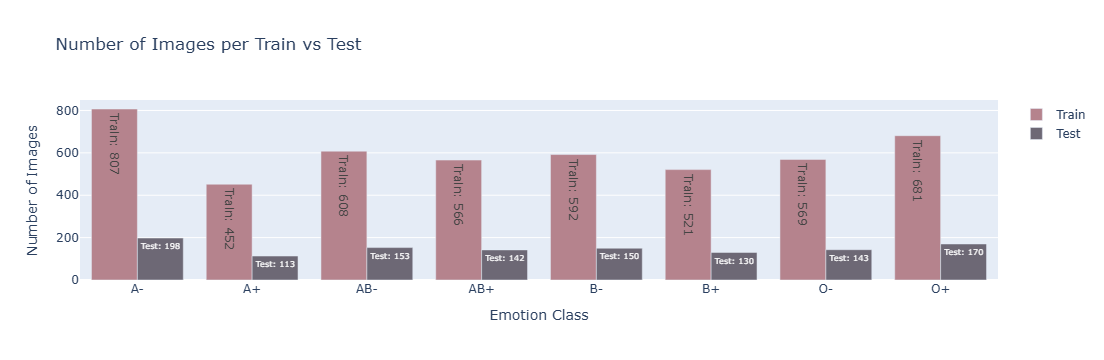

In [14]:
class_names = ['A-', 'A+', 'AB-', 'AB+', 'B-', 'B+', 'O-', 'O+']
train_dataset_path = r"D:\IMAGE DATA\ABT_TBM_658\BLOOD_GROUP_DATASET\train"
test_dataset_path =  r"D:\IMAGE DATA\ABT_TBM_658\BLOOD_GROUP_DATASET\test"
train_image_counts = []
test_image_counts = []
for class_name in class_names:
    train_class_path = os.path.join(train_dataset_path, class_name)
    test_class_path = os.path.join(test_dataset_path, class_name)
    train_num_images = len(os.listdir(train_class_path))
    test_num_images = len(os.listdir(test_class_path))
    train_image_counts.append(train_num_images)
    test_image_counts.append(test_num_images)
fig = go.Figure()
fig.add_trace(go.Bar(
    x=class_names,
    y=train_image_counts,
    name='Train',
    text=[f"Train: {x}" for x in train_image_counts],
    hoverinfo="text",
    marker_color='#b5838d' 
))

fig.add_trace(go.Bar(
    x=class_names,
    y=test_image_counts,
    name='Test',
    text=[f"Test: {x}" for x in test_image_counts],
    hoverinfo="text",
    marker_color='#6d6875' 
))

fig.update_layout(
    title='Number of Images per Train vs Test',
    barmode='group',
    xaxis_title='Emotion Class',
    yaxis_title='Number of Images',
    showlegend=True
)
fig.show()

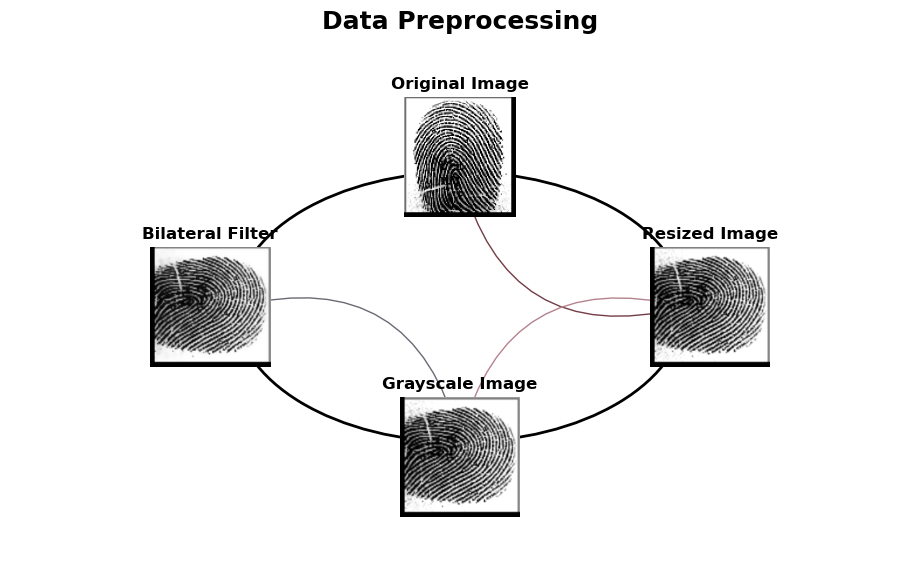

In [16]:
image_path = r'D:\IMAGE DATA\ABT_TBM_658\BLOOD_GROUP_DATASET\train\A-\cluster_1_307.BMP'
image = Image.open(image_path)
image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
img_resized = cv2.resize(image_cv, (150, 150))
gray_img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
bilateral_filtered = cv2.bilateralFilter(img_resized, 9, 75, 75)
fig, ax = plt.subplots(figsize=(10, 6))
positions = [
    (0.5, 0.75, image_cv, "Original Image", False),
    (0.75, 0.5, img_resized, "Resized Image", True),
    (0.5, 0.25, gray_img, "Grayscale Image", True),
    (0.25, 0.5, bilateral_filtered, "Bilateral Filter", True)
]
for x, y, img_data, title, rotate in positions:
    cmap = "gray" if len(img_data.shape) == 2 else None
    ax_inset = fig.add_axes([x - 0.1, y - 0.1, 0.2, 0.2])
    if rotate:
        img_data = cv2.rotate(img_data, cv2.ROTATE_90_CLOCKWISE)
    ax_inset.imshow(cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB) if cmap is None else img_data, cmap=cmap)
    ax_inset.set_title(title, fontsize=12, fontweight="bold")
    ax_inset.axis("off")

arrow1 = FancyArrowPatch((0.5, 0.75), (0.75, 0.5), connectionstyle="arc3,rad=.5", color="#723d46", arrowstyle="->", mutation_scale=15)
arrow2 = FancyArrowPatch((0.75, 0.5), (0.5, 0.25), connectionstyle="arc3,rad=.5", color="#b5838d", arrowstyle="->", mutation_scale=15)
arrow3 = FancyArrowPatch((0.5, 0.25), (0.25, 0.5), connectionstyle="arc3,rad=.5", color="#6d6875", arrowstyle="->", mutation_scale=15)
circle = Circle((0.5, 0.5), 0.25, edgecolor="black", facecolor="none", lw=2)
ax.add_patch(circle)
ax.add_patch(arrow1)
ax.add_patch(arrow2)
ax.add_patch(arrow3)
ax.axis("off")
ax.set_title("Data Preprocessing", fontsize=18, fontweight="bold", color="black")
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.show()


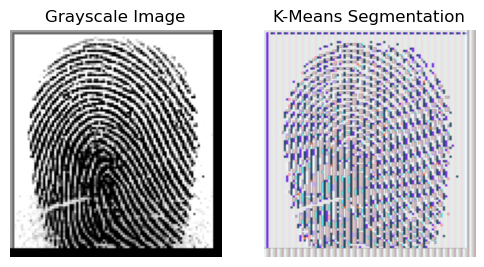

In [49]:
image = Image.open(image_path)
image = np.array(image)
pixels = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=3, n_init=10)
kmeans.fit(pixels)
segmented_pixels = kmeans.cluster_centers_[kmeans.labels_]
segmented_image = segmented_pixels.reshape(image.shape).astype(np.uint8)
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title("K-Means Segmentation")
plt.axis('off')
plt.show()

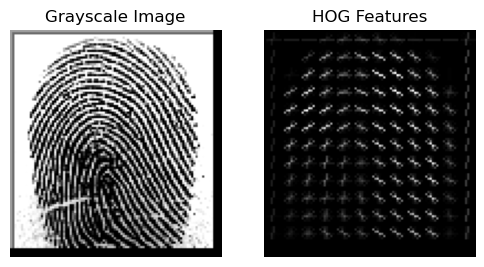

In [50]:
image = Image.open(image_path).convert("RGB")
image = np.array(image)
gray_image = color.rgb2gray(image)
_, hog_image = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                   visualize=True, feature_vector=False)
plt.figure(figsize=(6, 4))
plt.subplot(1, 2, 1)
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Features")
plt.axis('off')
plt.show()

In [61]:
train_dir = r"D:\IMAGE DATA\BLOOD_GROUP_DATASET\train"
test_dir = r"D:\IMAGE DATA\BLOOD_GROUP_DATASET\test"

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=32,
    shuffle=True
)

validation_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 4796 files belonging to 8 classes.
Found 1199 files belonging to 8 classes.


In [64]:
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), 
    layers.Dense(128, activation='relu'),
    layers.Dense(8, activation='softmax')  
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=15
)

Epoch 1/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.6454 - loss: 1.0061 - val_accuracy: 0.8432 - val_loss: 0.4088
Epoch 2/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.8064 - loss: 0.5060 - val_accuracy: 0.9074 - val_loss: 0.2208
Epoch 3/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.8667 - loss: 0.3644 - val_accuracy: 0.8949 - val_loss: 0.2570
Epoch 4/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.8905 - loss: 0.2964 - val_accuracy: 0.8857 - val_loss: 0.3074
Epoch 5/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.9014 - loss: 0.2640 - val_accuracy: 0.9466 - val_loss: 0.1237
Epoch 6/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.9244 - loss: 0.2007 - val_accuracy: 0.9683 - val_loss: 0.0868
Epoch 7/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.9433 - loss: 0.1615 - val_accuracy: 0.9491 - val_loss: 0.1525
Epoch 8/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9331 - loss: 0.1725 - val_accu

In [66]:
model.save("fingerprint.h5")

In [68]:
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - accuracy: 0.9837 - loss: 0.0431
Validation Loss: 0.0493
Validation Accuracy: 0.9842


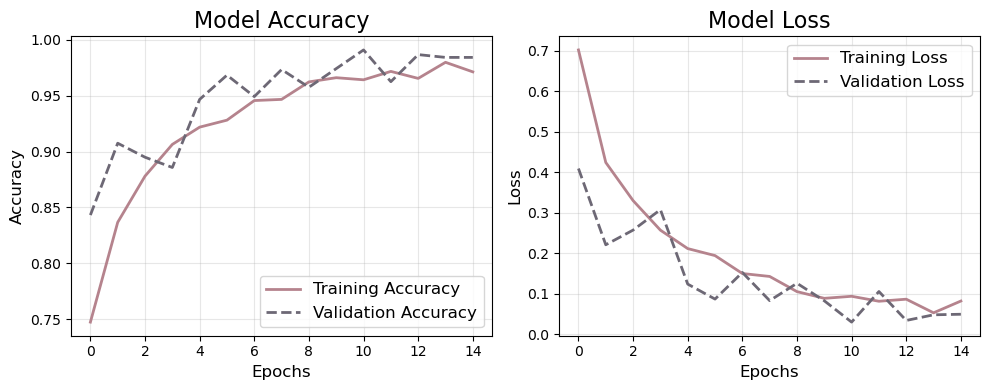

In [70]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='#b5838d', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#6d6875', linestyle='--', linewidth=2)
plt.title('Model Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='#b5838d', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='#6d6875', linestyle='--', linewidth=2)
plt.title('Model Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 363ms/step


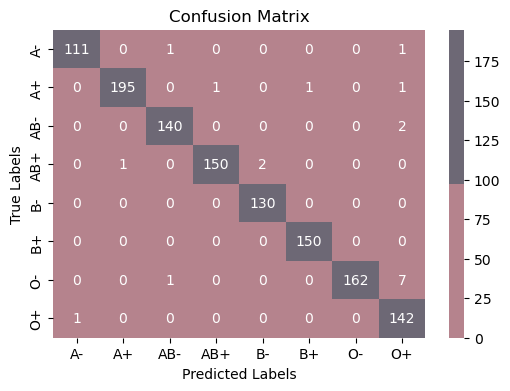

Classification Report:
               precision    recall  f1-score   support

          A-       0.99      0.98      0.99       113
          A+       0.99      0.98      0.99       198
         AB-       0.99      0.99      0.99       142
         AB+       0.99      0.98      0.99       153
          B-       0.98      1.00      0.99       130
          B+       0.99      1.00      1.00       150
          O-       1.00      0.95      0.98       170
          O+       0.93      0.99      0.96       143

    accuracy                           0.98      1199
   macro avg       0.98      0.98      0.98      1199
weighted avg       0.98      0.98      0.98      1199



In [72]:
class_names = ['A-', 'A+', 'AB-', 'AB+', 'B-', 'B+', 'O-', 'O+']
y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
y_pred = model.predict(validation_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
custom_cmap = ListedColormap(['#b5838d', '#6d6875'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap=custom_cmap, xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

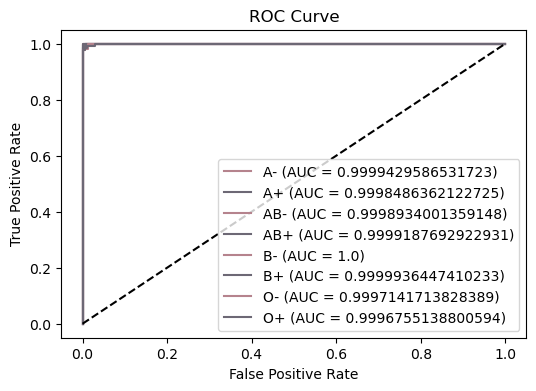

In [76]:
class_names = ['A-', 'A+', 'AB-', 'AB+', 'B-', 'B+', 'O-', 'O+']
y_true_bin = label_binarize(y_true, classes=list(range(8)))
y_pred_bin = y_pred  
plt.figure(figsize=(6, 4))
colors = ['#b5838d', '#6d6875']
for i in range(8):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:})", color=colors[i % 2]) 
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

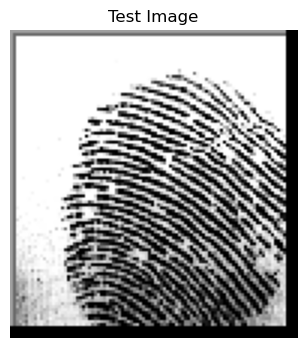

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: B-


In [94]:
classifier = load_model("fingerprint.h5")
class_names = ['A-', 'A+', 'AB-', 'AB+', 'B-', 'B+', 'O-', 'O+']
path = r"D:\IMAGE DATA\ABT_TBM_658\BLOOD_GROUP_DATASET\test\B-\cluster_3_236.BMP"
test_image = image.load_img(path)
plt.figure(figsize=(6, 4))  
plt.imshow(test_image)
plt.axis('off')
plt.title("Test Image")
plt.show()
test_img = image.load_img(path, target_size=(150, 150))
test_img = image.img_to_array(test_img)
test_img = np.expand_dims(test_img, axis=0)  
test_img = test_img / 255.0  
result = classifier.predict(test_img)
a = result.argmax()  
predicted_class = class_names[a]
print("Predicted Class:", predicted_class)